In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahilcodes","key":"add93beb5bdacaa83f2d67d8d74253f4"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tentotheminus9/seti-data

100% 5.25G/5.26G [02:24<00:00, 38.2MB/s]
100% 5.26G/5.26G [02:24<00:00, 39.1MB/s]


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from google.colab import files

In [ ]:
!unzip seti-data.zip

In [ ]:
!rm -rf /content/primary_small_v3

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import math
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger

In [ ]:
base_dir = "/content/primary_small"

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

print(train_dir)
print(test_dir)
print(val_dir)

/content/primary_small/train
/content/primary_small/test
/content/primary_small/valid


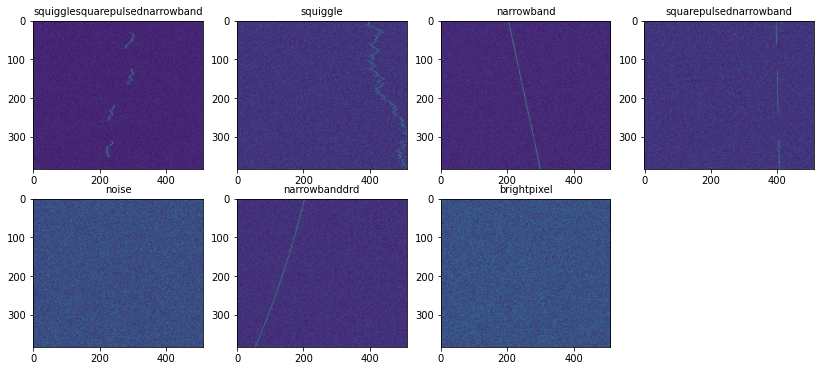

In [ ]:
data_signal_files = glob.glob(train_dir+'/*/*.png')
sample_files = [data_signal_files[idx] for idx in range(0,5600,800+15)]
fix, ax = plt.subplots(2,4,figsize=(14,6))

for idx, img in enumerate(sample_files):
    id1 = 1 if idx > 3 else 0
    id2 = idx % 4
    img_arr = img_to_array(load_img(img))
    f = ax[id1, id2].imshow(img_arr / 255., aspect='auto')
    t = ax[id1, id2].set_title(img.split('/')[-1].split('.')[0].split('_')[-1], fontsize=10)
ax[1,3].set_axis_off()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.05, rotation_range=180, vertical_flip=True,
                                  horizontal_flip=True, fill_mode='reflect')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_batch_size = 64
img_dim = (192, 192)
classes = ['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband']

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train_dir, classes=classes, target_size=img_dim, 
                                                    batch_size=train_batch_size, class_mode='categorical', interpolation='bicubic',
                                                   shuffle=True, seed=42)

val_generator = valid_datagen.flow_from_directory(directory=val_dir, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')


Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [ ]:
input_shape = (192, 192, 3)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.trainable = True
for layer in resnet.layers:
    resnet.trainable = True

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
base_resnet = resnet
base_out = base_resnet.output
pool_out = Flatten()(base_out)
hidden1 = Dense(1024, activation='relu')(pool_out)
drop1 = Dropout(rate=0.2)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.2)(hidden2)

out = Dense(7, activation='softmax')(drop2)

model = Model(inputs = base_resnet.input, outputs=out)
model.compile(optimizer=RMSprop(lr=1e-6), loss='categorical_crossentropy', metrics=[categorical_accuracy])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
csv_logger = CSVLogger('resent50_finetune_full_seti_log.csv', append=True)

history = model.fit_generator(train_generator, epochs = 100, 
                              validation_data=val_generator, callbacks=[csv_logger], verbose=1)

Epoch 1/100
88/88 [==============================] - 146s 2s/step - loss: 1.8982 - categorical_accuracy: 0.3520 - val_loss: 34.4869 - val_categorical_accuracy: 0.1429
Epoch 2/100
88/88 [==============================] - 145s 2s/step - loss: 1.7473 - categorical_accuracy: 0.3991 - val_loss: 72.4902 - val_categorical_accuracy: 0.1429
Epoch 3/100
88/88 [==============================] - 146s 2s/step - loss: 1.5751 - categorical_accuracy: 0.4448 - val_loss: 82.5141 - val_categorical_accuracy: 0.1429
Epoch 4/100
88/88 [==============================] - 146s 2s/step - loss: 1.4941 - categorical_accuracy: 0.4616 - val_loss: 85.5418 - val_categorical_accuracy: 0.1500
Epoch 5/100
88/88 [==============================] - 146s 2s/step - loss: 1.4257 - categorical_accuracy: 0.4920 - val_loss: 90.6260 - val_categorical_accuracy: 0.1429
Epoch 6/100
88/88 [==============================] - 145s 2s/step - loss: 1.3829 - categorical_accuracy: 0.5027 - val_loss: 87.2944 - val_categorical_accuracy: 0.151

In [ ]:
model_name = 'seti-signal-classifier_resnet50.h5'
path = F"/content/gdrive/My Drive/{model_name}"
model.save(path, overwrite=True)

In [ ]:
test_generator = test_datagen.flow_from_directory(directory=test_dir, classes=classes, target_size=img_dim, batch_size=1,
                                                 class_mode='categorical', interpolation='bicubic', shuffle=False, seed=42)
class_label_mapping = {v:k for k,v in test_generator.class_indices.items()}
test_data = [next(test_generator) for i in range(700)]
test_data_X = [data[0] for data in test_data]
test_data_X = np.array(np.squeeze(test_data_X, axis=1))
test_data_y = np.array([fname.split('/')[0] for fname in test_generator.filenames])
class_labels = list(set(test_data_y))

test_data_X.shape, test_data_y.shape

Found 700 images belonging to 7 classes.


((700, 192, 192, 3), (700,))

In [ ]:
def evaluate_model_results(model, test_data, test_labels, 
                           class_label_mapping, class_labels):
    predictions = model.predict(test_data, verbose=1)
    prediction_labels = [class_label_mapping[idx] for idx in predictions.argmax(axis=1)]
    print(classification_report(y_true=test_labels, y_pred=prediction_labels))
    return pd.DataFrame(confusion_matrix(y_true=test_labels, y_pred=prediction_labels, labels=class_labels),
                        index=class_labels, columns=class_labels)

In [ ]:
evaluate_model_results(model, test_data_X, test_data_y, class_label_mapping, class_labels)

22/22 [==============================] - 4s 189ms/step
                                precision    recall  f1-score   support

                   brightpixel       0.94      0.67      0.78       100
                    narrowband       0.71      0.85      0.78       100
                 narrowbanddrd       0.79      0.58      0.67       100
                         noise       0.65      0.92      0.76       100
        squarepulsednarrowband       0.73      0.69      0.71       100
                      squiggle       0.89      0.86      0.87       100
squigglesquarepulsednarrowband       0.75      0.79      0.77       100

                      accuracy                           0.77       700
                     macro avg       0.78      0.77      0.76       700
                  weighted avg       0.78      0.77      0.76       700



,squarepulsednarrowband,squiggle,squigglesquarepulsednarrowband,narrowband,noise,brightpixel,narrowbanddrd
squarepulsednarrowband,69,0,12,4,12,0,3
squiggle,0,86,4,5,1,0,4
squigglesquarepulsednarrowband,15,2,79,0,4,0,0
narrowband,0,5,0,85,2,0,8
noise,1,2,3,0,92,2,0
brightpixel,8,0,4,0,21,67,0
narrowbanddrd,1,2,3,25,9,2,58


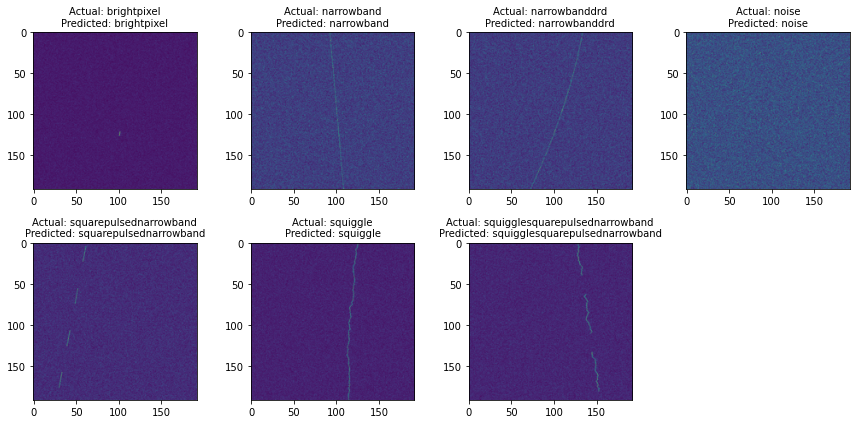

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for idx, img_idx in enumerate([15, 123, 230, 340, 450, 560, 670]):
    id1 = 1 if idx > 3 else 0
    id2 = idx % 4
    predicted_label = class_label_mapping[
                            np.argmax(
                                model.predict(
                                    np.array([test_data_X[img_idx]])
                                ),axis=1
                            )[0]
    ]
    f = ax[id1, id2].imshow(test_data_X[img_idx], aspect='auto')
    t = ax[id1, id2].set_title('Actual: {}\nPredicted: {}'.format(test_data_y[img_idx],
                                                                  predicted_label), 
                               fontsize=10)
ax[1,3].set_axis_off()
fig.tight_layout()

In [ ]:
!nvidia-smi -l

Thu Oct 15 16:02:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    60W / 149W |   8683MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

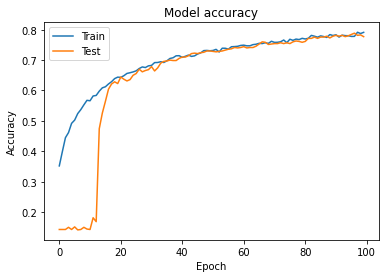

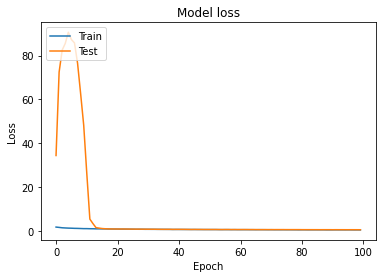

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

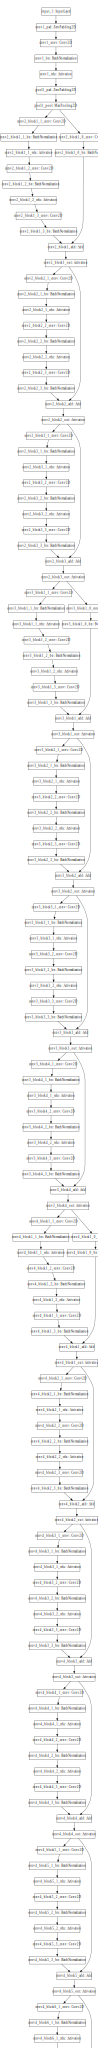

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))